<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/chess_players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

In [4]:
import h5py
data = h5py.File('/content/drive/My Drive/chess_players/chess_players.h5', "r")
print(np.array(data))
XX = data["X"][:]
Z = data["Z"][:]
later=Z

num = XX.shape[0] 
print(XX.shape,Z.shape,num)

['X' 'Z']
(552, 224, 224, 3) (552,) 552


In [0]:
imgsize=224

In [6]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
Z = to_categorical(Z,6)
X = XX/255

# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)

(441, 224, 224, 3) (441, 6)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
augs_gen.fit(x_train)

552


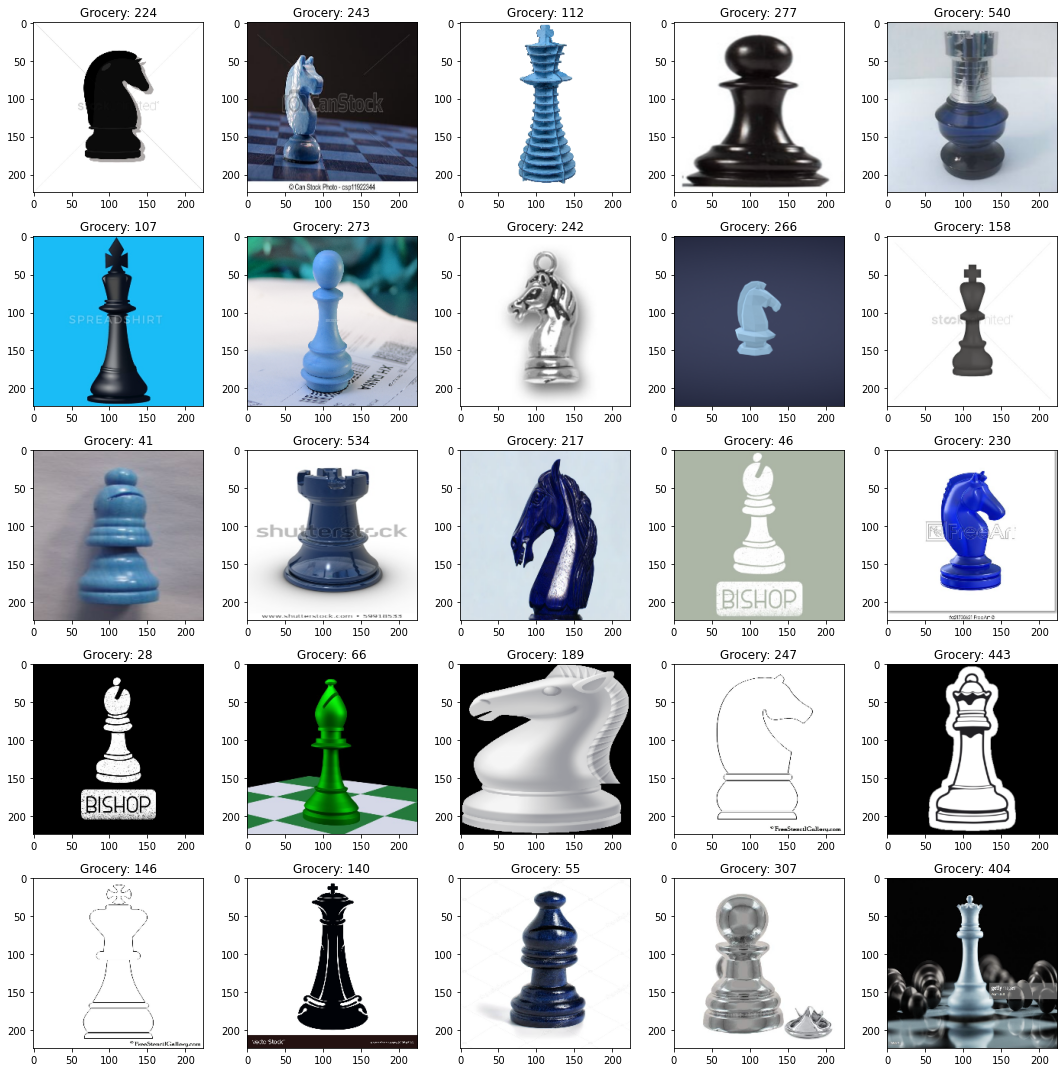

In [8]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(XX[l])
        ax[i,j].set_title('Grocery: '+ str(l))
        
plt.tight_layout()

553467904/553467096 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

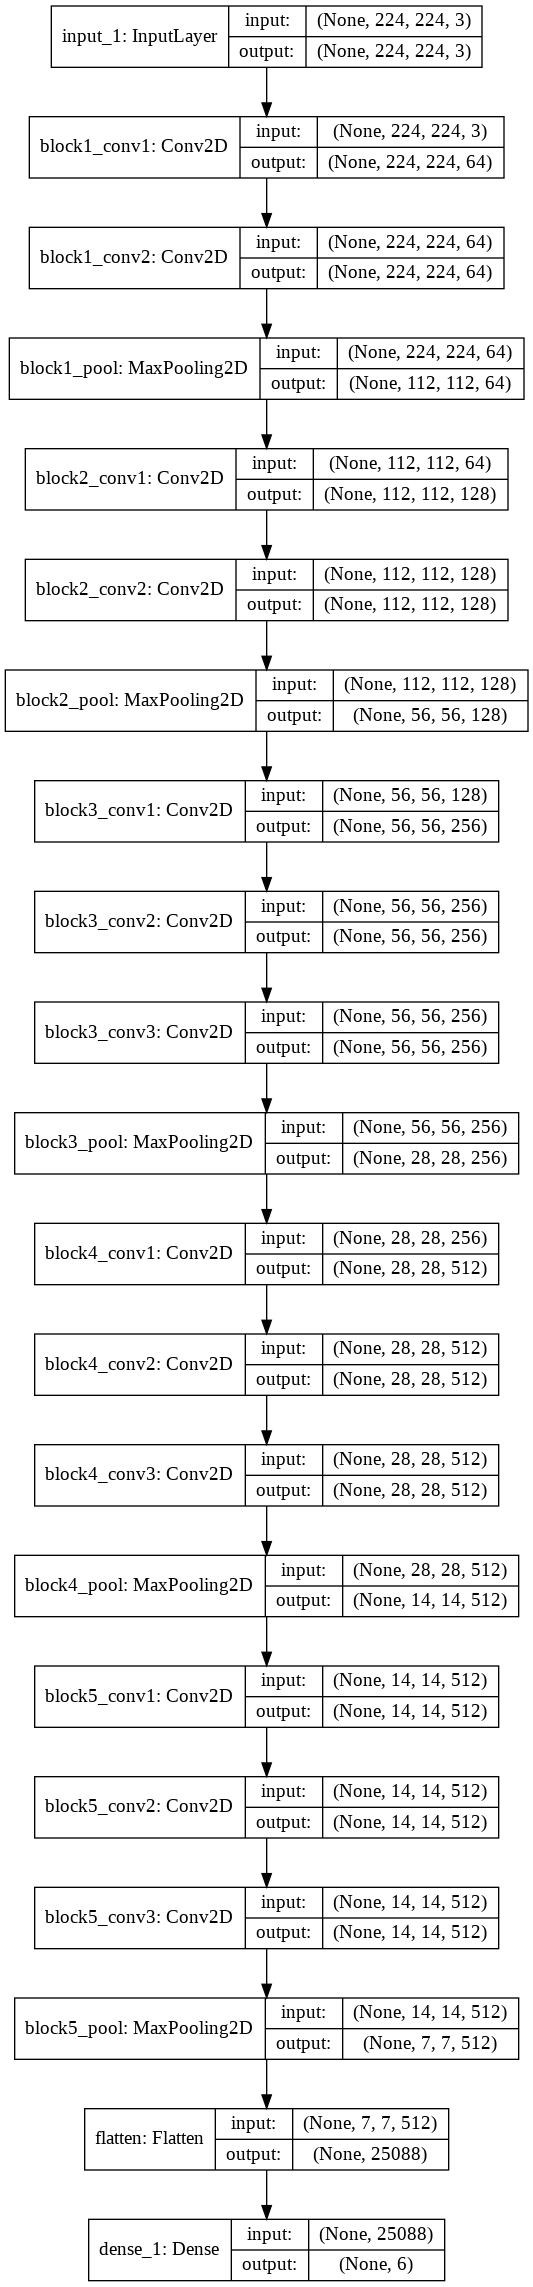

In [9]:
ct=0
base_model = VGG16(include_top=True,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()


model = Sequential()
for layer in base_model.layers:
  model.add(layer)

for layer in base_model.layers:
  ct=ct+1

for layer in base_model.layers:
  if ct>4:
    layer.trainable = False
  else:
    layer.trainable = True
  ct=ct-1
  print(layer,layer.trainable)



# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
# model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]
# callbacks = [earlystop,tensorboard,csvlogger,reduce]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [11]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

history = model.fit(
    x_train,y_train,batch_size=32,
    validation_data  = (x_test,y_test),
    # validation_steps = 100,
    # steps_per_epoch  = 10,
    epochs = 18, 
    verbose = 1,
    callbacks=callbacks
)
# history = model.fit_generator(
#     augs_gen.flow(x_train,y_train,batch_size=32),
#     validation_data  = (x_test,y_test),
#     validation_steps = 100,
#     # steps_per_epoch  = 100,
#     epochs =100, 
#     verbose = 1,
#     callbacks=callbacks
# )

Train on 441 samples, validate on 111 samples
Epoch 1/18
441/441 [==============================] - 22s 50ms/step - loss: 2.2769 - accuracy: 0.2902 - val_loss: 1.6513 - val_accuracy: 0.4865
Epoch 2/18


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


441/441 [==============================] - 7s 15ms/step - loss: 0.9286 - accuracy: 0.6553 - val_loss: 0.7288 - val_accuracy: 0.7297
Epoch 3/18
441/441 [==============================] - 7s 15ms/step - loss: 0.4327 - accuracy: 0.8367 - val_loss: 0.5228 - val_accuracy: 0.7928
Epoch 4/18
441/441 [==============================] - 7s 15ms/step - loss: 0.2273 - accuracy: 0.9138 - val_loss: 0.5030 - val_accuracy: 0.8559
Epoch 5/18
441/441 [==============================] - 7s 15ms/step - loss: 0.1192 - accuracy: 0.9660 - val_loss: 0.4371 - val_accuracy: 0.8378
Epoch 6/18
441/441 [==============================] - 7s 15ms/step - loss: 0.1101 - accuracy: 0.9615 - val_loss: 0.3691 - val_accuracy: 0.8919
Epoch 7/18
441/441 [==============================] - 7s 15ms/step - loss: 0.0811 - accuracy: 0.9773 - val_loss: 0.4257 - val_accuracy: 0.8739
Epoch 8/18
441/441 [==============================] - 7s 15ms/step - loss: 0.0324 - accuracy: 0.9909 - val_loss: 0.6172 - val_accuracy: 0.8378
Epoch 9/18

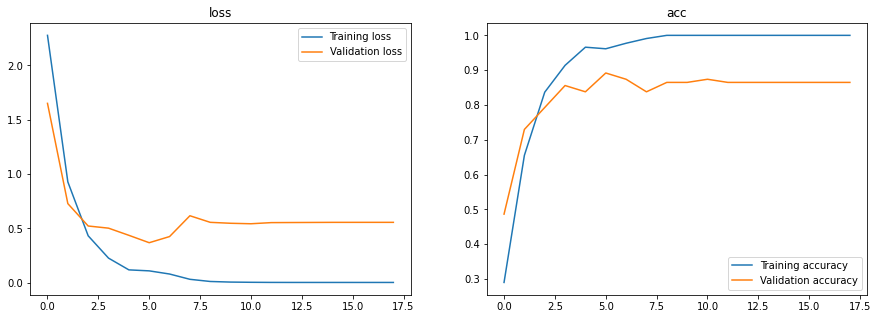

In [12]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [14]:
# use x 
a=model.evaluate(x_train,y_train)
b=model.evaluate(x_test,y_test)

print("Final loss of training data: {}".format(a[0]))
print("Accuracy of training data: {}".format(a[1]))
print("Final loss of test data: {}".format(b[0]))
print("Accuracy of test data: {}".format(b[1]))

ind=0

111/111 [==============================] - 1s 11ms/step
Final loss of training data: 0.003533339400325908
Accuracy of training data: 1.0
Final loss of test data: 0.5564924857100925
Accuracy of test data: 0.8648648858070374


In [40]:
tp=fp=tn=fn=0
for ind in range(len(x_test)):
  a1,b1,c1=x_test[ind].shape
  ans1=np.argmax(model.predict(x_test[ind].reshape(1,a1,b1,c1)))
  ans2=np.argmax(y_test[ind])
  if ans1==ans2:
    ct=ct+1
tot=len(x_test)
print(ct/tot)



0.8648648648648649


In [81]:
from sklearn.metrics import confusion_matrix
y_true=[]
y_pred=[]
# ['Bishop', 'King', 'Knight' , 'Pawn', 'Queen' , 'Rook']
classes=[0,1,2,3,4,5]

for ind in range(len(x_test)):
  a1,b1,c1=x_test[ind].shape
  ans1=np.argmax(model.predict(x_test[ind].reshape(1,a1,b1,c1)))
  y_pred.append(ans1)
  ans2=np.argmax(y_test[ind])
  y_true.append(ans2)
cm=confusion_matrix(y_true, y_pred, labels=classes)
cm

array([[18,  1,  2,  2,  2,  0],
       [ 1, 13,  0,  0,  2,  0],
       [ 0,  0, 17,  0,  0,  0],
       [ 0,  1,  0, 21,  0,  0],
       [ 0,  2,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  2, 22]])

In [47]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(recall,precision)

[0.72       0.8125     1.         0.95454545 0.71428571 0.91666667] [0.94736842 0.76470588 0.89473684 0.91304348 0.45454545 1.        ]


array([1., 0., 0., 0., 0., 0.], dtype=float32)

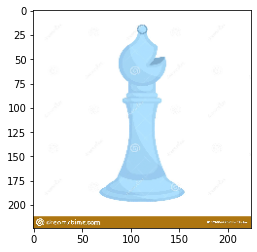

In [79]:
ind=172
plt.imshow(x_train[ind])
y_train[ind]
            #     Bishop(1)  King(2)  Knight(3)        Pawn(4)           Queen(5)              Rook(6)

In [0]:
# from sklearn.metrics import confusion_matrix

# y_true = ['Cat', 'Dog', 'Rabbit', 'Cat', 'Cat', 'Rabbit']
# y_pred = ['Dog', 'Dog', 'Rabbit', 'Dog', 'Dog', 'Rabbit']

# classes=['Cat', 'Dog', 'Rabbit']

# confusion_matrix(y_true, y_pred, labels=['Cat', 'Dog', 'Rabbit'])



(552, 6)
15
4 1
4 2


IndexError: ignored

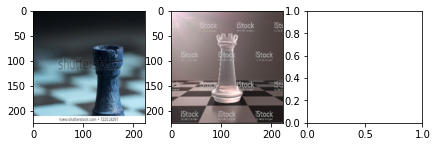

In [15]:
ans=model.predict(X)
print(ans.shape)
ma=np.argmax(ans,axis=1)
lis=ma-later
index=[]
for i in range(552):
  if lis[i]==0:
    pass
  else:
    index.append(i)

print(len(index))
plt.figure(figsize=(7,7))

ind=13
# for i in range(5):
plt.subplot(3,3,1)
plt.imshow(X[index[ind]])
print(ma[index[ind]],1)

plt.subplot(3,3,2)
plt.imshow(X[index[ind+1]])
print(ma[index[ind+1]],2)

plt.subplot(3,3,3)
plt.imshow(X[index[ind+2]])
print(ma[index[ind+2]],3)

plt.subplot(3,3,4)
plt.imshow(X[index[ind+3]])
print(ma[index[ind+3]],4)

plt.subplot(3,3,5)
plt.imshow(X[index[ind+4]])
print(ma[index[ind+4]],5)
plt.subplot(3,3,6)
plt.imshow(X[index[ind+5]])
print(ma[index[ind+5]],6)

plt.subplot(3,3,7)
plt.imshow(X[index[ind+6]])
print(ma[index[ind+6]],7)

plt.subplot(3,3,8)
plt.imshow(X[index[ind+7]])
print(ma[index[ind+7]],8)

plt.subplot(3,3,9)
plt.imshow(X[index[ind+8]])
print(ma[index[ind+8]],9)
ind=16
# plt.subplot(3,3,10)
# plt.imshow(X[ind+9])
print(ind)
# camel   king   horse  sipahi  queen   elephant
  # 0       1      2       3       4        5